## Visualizing Census Tract Internet Data

### By: Kaya and Maia

#### Adapted from: fcc_analysis.ipynb

In [1]:
### helper functions ###

def merge_data(nhood_df, ctract_df, merged_df_path):
    '''
    This function takes the neighborhood data and census level data, merges them, and writes
    the merged df to a specified file location.
    
    Inputs:
      nhood_df: dataframe to go on outside (in this case neighborhood df)
      ctract_df: dataframe to go within the other df (census tract fcc_df)
    Returns:
      merged_df: merged dataframe, which this functions saves as csv to file location
    '''
    # should work if geographies are in the same format
    try:
        merged_df = geopandas.sjoin(ctract_df, nhood_df, how="inner", op='intersects')
        merged_df.to_file(merged_df_path, driver="GeoJSON")
        return merged_df
    # if not we may need to change the crs of the neighborhood data
    except:
        nhood_df = nhood_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
        merged_df = geopandas.sjoin(ctract_df, nhood_df, how="inner", op='intersects')
        merged_df.to_file(merged_df_path, driver="GeoJSON")
        return merged_df
        


def get_nhood_avgs(city_df, city_fcc_df, nhood_col):
    '''
    Updates df to have a column for the average broadband for each census tract
    '''
    nhood_avgs = {}
    
    normal_avgs = []
    city_bband_avg = []
    i = 0
    for nhood in city_df[nhood_col]:
        ctracts = city_fcc_df.loc[city_fcc_df[nhood_col] == nhood]
        nhood_avg = 0
        null_bband = 0
        for tract in list(ctracts['f_broadband']):
            if not math.isnan(tract):
                nhood_avg = nhood_avg + float(tract)
            else:
                null_bband += 1
        if null_bband == len(ctracts['f_broadband']):
            normal_avgs.append(math.nan)
        else:
            normal_avgs.append(nhood_avg / (len(ctracts['f_broadband']) - null_bband))
    
    city_df['bband_avg'] = normal_avgs
    
def plot_boxplots(city_fcc_df, nhood_col, title):
    '''
    Plot basic boxplot for city_fcc_df.
    
    Inputs:
      city_fcc_df: City fcc df (neighborhood data merged with FCC data)
      nhood_col: Column name for neighborhood indicators
      title: Title for boxplot figure
    
    Outputs:
      Boxplot
    '''
    
    city_fcc_df.boxplot(column='f_broadband', by=nhood_col, rot=90, figsize=(15,10), grid=False,
                       fontsize=8, color='green')
    plt.ylabel('f_broadband')
    plt.xlabel('Neighborhood Indicator')
    plt.title(title)
    plt.suptitle('')

In [2]:
import geopandas
import contextily as cx
import warnings
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
sys.path[0] = os.path.join(os.path.abspath(''),'..')

In [4]:
import data_pipeline.spatial_operations as so

In [5]:
# import fcc geojson
fcc_df = geopandas.read_file("/tmp/internet-access-map/data/broadband.geojson")

In [6]:
fcc_df.head()

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
0,34005702808,2.143,2.143,1.000,1.000,0.000,0.000,1000.000,35.000,0.910,...,3353.0,1055.0,31.62,20.18,305.57,20.75,14.66,0.009,0.006,"POLYGON ((-74.90801 40.03250, -74.90496 40.036..."
1,39153504200,3.286,2.457,1.000,1.000,0.000,0.000,940.000,35.000,0.634,...,1708.0,694.0,48.11,19.26,162.57,12.29,27.06,0.028,0.011,"POLYGON ((-81.51807 41.05957, -81.51805 41.062..."
2,36071000502,2.857,2.776,1.939,1.939,0.939,0.939,940.000,828.265,0.508,...,3763.0,1204.0,33.07,23.37,267.28,76.41,12.45,0.009,0.006,"POLYGON ((-74.02226 41.49281, -74.02180 41.496..."
3,06013370000,3.840,3.693,2.680,1.613,0.747,0.747,875.333,784.667,0.925,...,2850.0,1137.0,289.57,60.46,261.09,127.88,12.62,0.102,0.021,"POLYGON ((-122.32697 37.93502, -122.32611 37.9..."
4,48113019204,2.714,2.590,1.638,1.619,0.619,0.619,977.143,632.381,0.890,...,10051.0,2718.0,320.81,127.74,246.56,108.10,17.63,0.032,0.013,"POLYGON ((-96.76903 32.94655, -96.76899 32.950..."


<br></br>

### City One: Seattle

In [7]:
seattle_df = geopandas.read_file("/tmp/neighborhood-data/seattle/seattle_ccn/City_Clerk_Neighborhoods.shp")

In [8]:
seattle_fcc_df = merge_data(seattle_df, fcc_df, "/tmp/neighborhood-data/seattle/seattle_fcc_df.geojson")

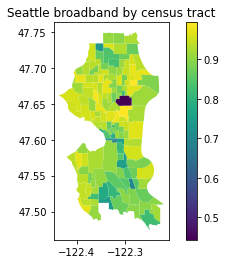

In [9]:
so.simple_map(seattle_fcc_df.drop_duplicates(subset='geometry'), 'f_broadband', 'geoid', 'Seattle broadband by census tract')

In [10]:
get_nhood_avgs(seattle_df, seattle_fcc_df, 'HOODS_')

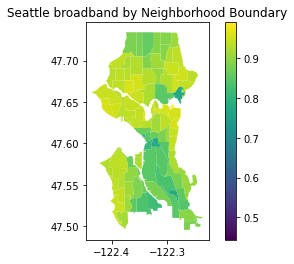

In [11]:
so.simple_map(seattle_df, 'bband_avg', 'HOODS_', 'Seattle broadband by Neighborhood Boundary')

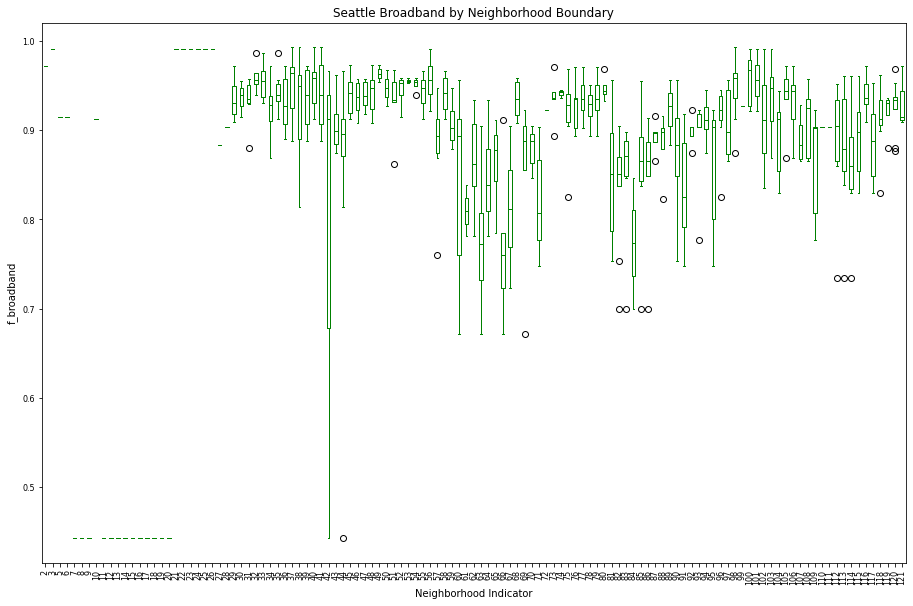

In [12]:
plot_boxplots(seattle_fcc_df, 'HOODS_', 'Seattle Broadband by Neighborhood Boundary')

### City Two: Denver

In [13]:
denver_df = geopandas.read_file("/tmp/neighborhood-data/denver/denver_1.0.32/statistical_neighborhoods.shp")

In [14]:
denver_fcc_df = merge_data(denver_df, fcc_df, "/tmp/neighborhood-data/denver/denver_fcc_df.geojson")

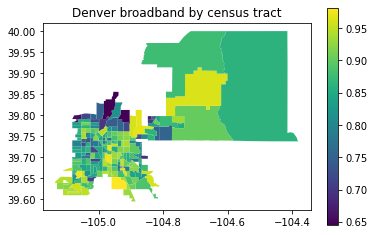

In [15]:
so.simple_map(denver_fcc_df.drop_duplicates(subset='geometry'), 'f_broadband', 'geoid', 'Denver broadband by census tract')

In [16]:
get_nhood_avgs(denver_df, denver_fcc_df, 'NBHD_ID')

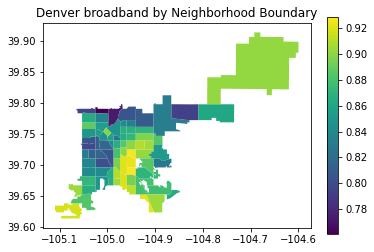

In [17]:
so.simple_map(denver_df, 'bband_avg', 'NBHD_ID', 'Denver broadband by Neighborhood Boundary')

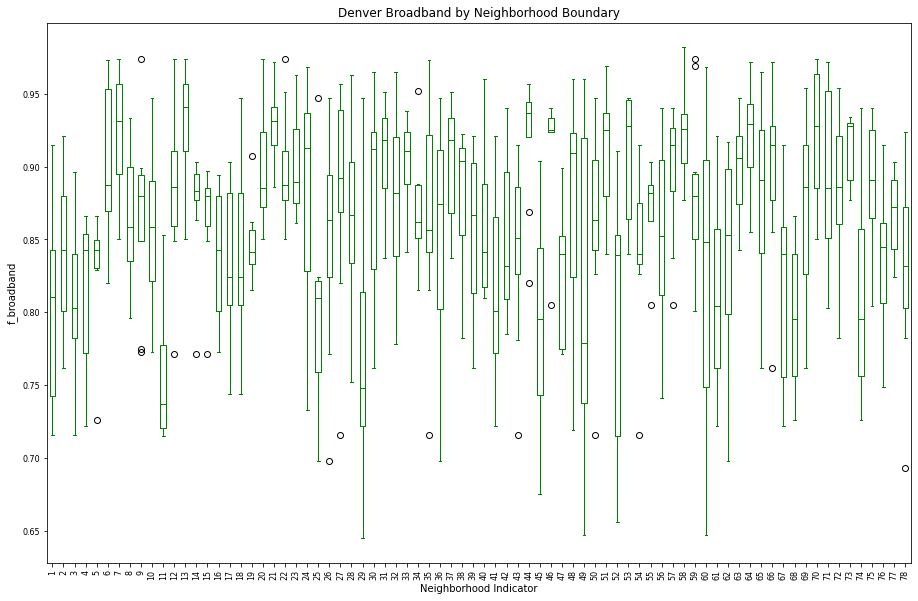

In [18]:
plot_boxplots(denver_fcc_df, 'NBHD_ID', 'Denver Broadband by Neighborhood Boundary')

### City Three: Albuquerque

In [19]:
alb_df = geopandas.read_file("/tmp/neighborhood-data/albuquerque/albuquerque-shp/nbr.shp")

In [20]:
alb_df = alb_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [21]:
alb_fcc_df = merge_data(alb_df, fcc_df, "/tmp/neighborhood-data/albuquerque/alb_fcc_df.geojson")

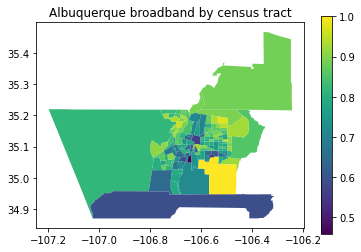

In [22]:
so.simple_map(alb_fcc_df.drop_duplicates(subset='geometry'), 'f_broadband', 'geoid', 'Albuquerque broadband by census tract')

In [23]:
get_nhood_avgs(alb_df, alb_fcc_df, 'Associatio')

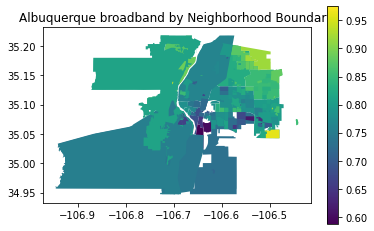

In [24]:
so.simple_map(alb_df, 'bband_avg', 'Associatio', 'Albuquerque broadband by Neighborhood Boundary')

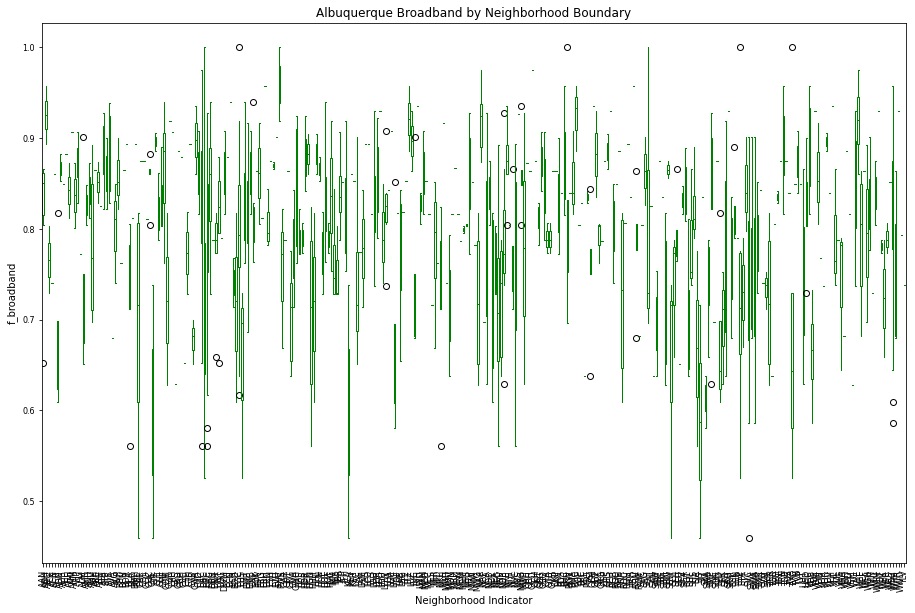

In [25]:
plot_boxplots(alb_fcc_df, 'Associatio', 'Albuquerque Broadband by Neighborhood Boundary')

### City Four: Washington, D.C.

In [26]:
dc_df = geopandas.read_file("/tmp/neighborhood-data/washington-dc/DC_shapefile/Neighborhood_Clusters.shp")

In [27]:
dc_fcc_df = merge_data(dc_df, fcc_df, "/tmp/neighborhood-data/washington-dc/dc_fcc_df.geojson")

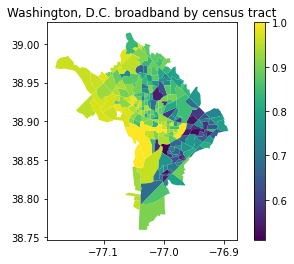

In [28]:
so.simple_map(dc_fcc_df.drop_duplicates(subset='geometry'), 'f_broadband', 'geoid', 'Washington, D.C. broadband by census tract')

In [29]:
get_nhood_avgs(dc_df, dc_fcc_df, 'NAME')

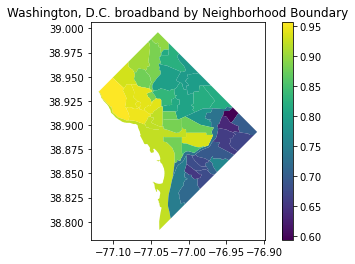

In [30]:
so.simple_map(dc_df, 'bband_avg', 'NAME', 'Washington, D.C. broadband by Neighborhood Boundary')

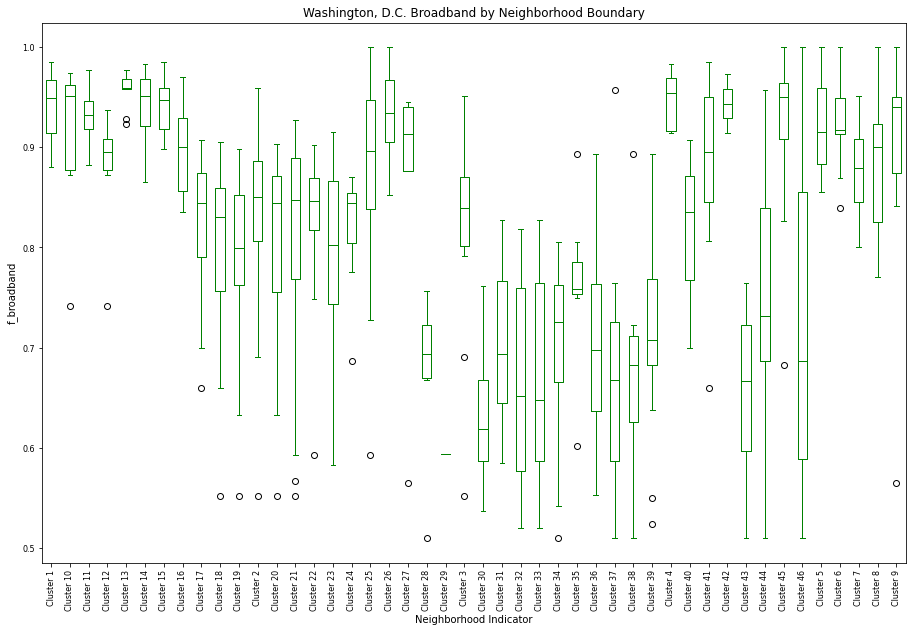

In [31]:
plot_boxplots(dc_fcc_df, 'NAME', 'Washington, D.C. Broadband by Neighborhood Boundary')

### City Five: Boston

In [32]:
boston_df = geopandas.read_file("/tmp/neighborhood-data/boston/Boston_Neighborhoods/Boston_Neighborhoods.shp")

In [33]:
boston_fcc_df = merge_data(boston_df, fcc_df, "/tmp/neighborhood-data/boston/boston_fcc_df.geojson")

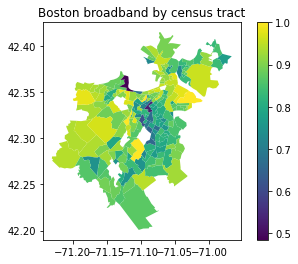

In [34]:
so.simple_map(boston_fcc_df.drop_duplicates(subset='geometry'), 'f_broadband', 'geoid', 'Boston broadband by census tract')

In [35]:
get_nhood_avgs(boston_df, boston_fcc_df, 'Name')

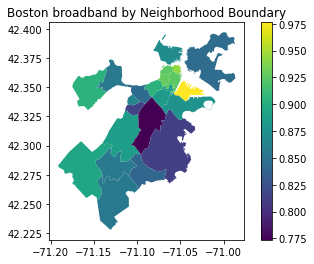

In [36]:
so.simple_map(boston_df, 'bband_avg', 'Name', 'Boston broadband by Neighborhood Boundary')

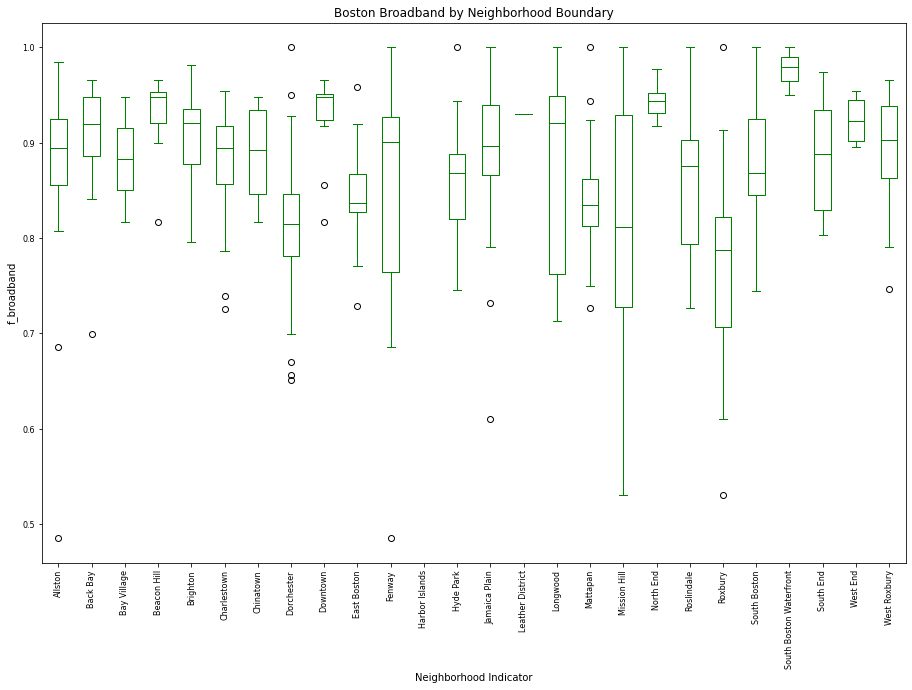

In [37]:
plot_boxplots(boston_fcc_df, 'Name', 'Boston Broadband by Neighborhood Boundary')

### City Six: Portland

In [38]:
portland_df = geopandas.read_file("/tmp/neighborhood-data/portland/portland-neighborhood-boundaries/Neighborhood_Boundaries.shp")

In [39]:
portland_df = portland_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [40]:
portland_fcc_df = merge_data(portland_df, fcc_df, "/tmp/neighborhood-data/portland/portland_fcc_df.geojson")

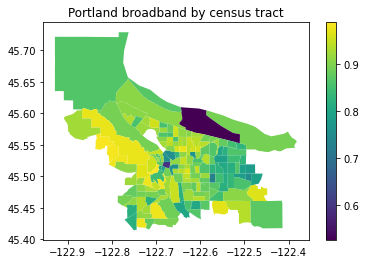

In [41]:
so.simple_map(portland_fcc_df.drop_duplicates(subset='geometry'), 'f_broadband', 'geoid', 'Portland broadband by census tract')

In [42]:
get_nhood_avgs(portland_df, portland_fcc_df, 'ID')

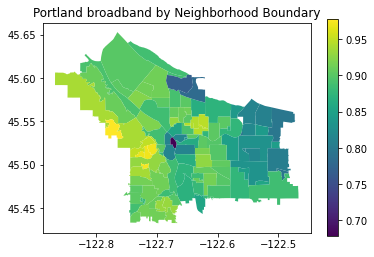

In [43]:
so.simple_map(portland_df, 'bband_avg', 'ID', 'Portland broadband by Neighborhood Boundary')

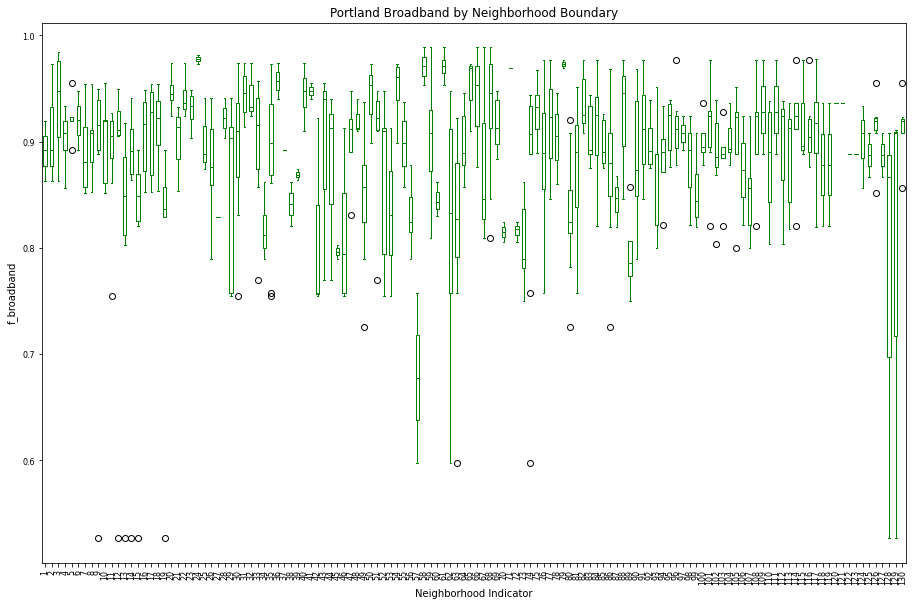

In [44]:
plot_boxplots(portland_fcc_df, 'ID', 'Portland Broadband by Neighborhood Boundary')

<br> </br>

.

<br> </br>

.
<br> </br>

<br> </br>

#### OUR OLD WORK

In [45]:
countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
cities = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))

Get Census IDs (from https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::census-tracts-2010/explore?location=47.607831%2C-122.342050%2C12.05&showTable=true)

In [46]:
# census df
seattle_census = pd.read_csv("/tmp/neighborhood-data/seattle/Census_Tracts_2010.csv")

In [47]:
seattle_census.head()

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area
0,1,2500,2500,53033002500,25.0,Census Tract 25,243.219083,0,16442.968402,1.059462e+07
1,2,2600,2600,53033002600,26.0,Census Tract 26,307.584420,0,15936.137058,1.339838e+07
2,3,5600,5600,53033005600,56.0,Census Tract 56,737.511727,0,30337.294354,3.212601e+07
3,4,6800,6800,53033006800,68.0,Census Tract 68,177.438771,0,11275.376490,7.729233e+06
4,5,6000,6000,53033006000,60.0,Census Tract 60,324.567432,0,19729.922875,1.413816e+07


In [48]:
# pull out a list of indexes:
indexes = []
for tract in seattle_census['GEOID10']:
    temp = fcc_df['geoid'].isin([str(tract)])
    loc = list(temp).index(True)
    indexes.append(loc)

In [49]:
seattle_fcc_df = fcc_df.loc[indexes]

In [50]:
seattle_fcc_df.head()

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
8291,53033002500,3.745,3.723,2.468,2.000,1.000,1.000,1000.000,940.000,0.875,...,3451.0,1333.0,192.89,70.90,201.55,118.98,8.56,0.056,0.021,"POLYGON ((-122.30685 47.69030, -122.30167 47.6..."
38019,53033002600,3.321,3.190,2.571,1.869,0.905,0.905,945.714,855.238,0.962,...,5377.0,1989.0,336.83,136.39,215.24,170.29,7.07,0.063,0.025,"POLYGON ((-122.31758 47.68855, -122.31344 47.6..."
50258,53033005600,3.226,3.026,2.333,1.200,0.297,0.297,912.308,314.718,0.953,...,7038.0,2850.0,621.17,178.86,225.55,69.57,13.22,0.088,0.025,"POLYGON ((-122.41992 47.65284, -122.41988 47.6..."
12334,53033006800,5.194,5.129,3.677,2.677,0.968,0.968,999.032,911.290,0.919,...,3472.0,1487.0,347.23,98.68,222.03,127.26,9.43,0.100,0.028,"POLYGON ((-122.36227 47.63960, -122.36093 47.6..."
66668,53033006000,3.713,3.409,2.722,1.704,0.591,0.591,782.174,568.957,0.973,...,6300.0,2758.0,376.89,137.23,204.41,118.89,11.21,0.060,0.022,"POLYGON ((-122.36090 47.64665, -122.36089 47.6..."


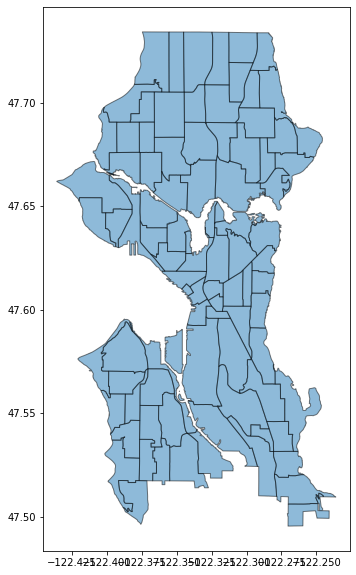

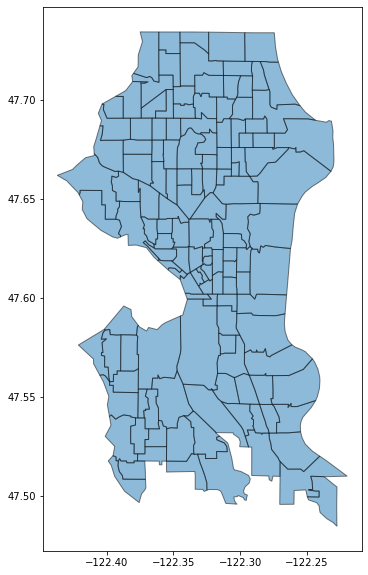

In [51]:
seattle_ax = seattle_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
seattle_fcc_ax = seattle_fcc_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

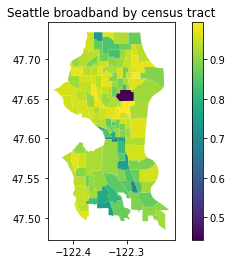

In [52]:
so.simple_map(seattle_fcc_df, 'f_broadband', 'geoid', 'Seattle broadband by census tract')

#### SO, we need to group the census tracts into neighborhoods and we are good to go! This is changing out df, doesn't require adapting their simple map code

In [53]:
len(seattle_df['geometry'])

119

In [54]:
neighborhoods = {}
indexes = []
for i, poly in enumerate(seattle_fcc_df['geometry']):
    for j, nhood in enumerate(seattle_df['geometry']):
        if nhood.intersects(poly):
            temp = neighborhoods.get(j, [])
            temp.append(i)
            neighborhoods[j] = temp

In [55]:
neighborhoods

{35: [0, 1, 26, 28, 46, 47, 48, 50, 54, 55],
 40: [0, 1, 24, 27, 29, 50, 53],
 95: [0, 1, 25, 26, 27, 28, 54, 55],
 115: [1, 24, 27, 28, 29, 33, 35],
 49: [2, 6, 8, 11, 127],
 50: [2, 6],
 51: [2, 6, 8, 127],
 65: [2, 5, 6, 8, 11, 123, 126, 127],
 42: [3, 4, 81, 83, 128],
 43: [3, 5, 126, 127, 128, 129],
 44: [3, 81, 123, 125, 126, 127, 128, 129],
 45: [3, 4, 5, 8, 127, 129],
 46: [4, 81],
 30: [7, 9, 12, 13, 14, 15, 16, 17, 45, 52],
 31: [7, 12, 42, 43, 45, 51, 52, 53, 83],
 32: [7, 9, 10, 12, 45, 83],
 29: [9, 10, 13, 14],
 27: [10, 11, 14],
 2: [11],
 3: [11],
 26: [11, 14, 17, 18, 21, 22],
 118: [11, 18, 22],
 33: [12, 15, 24, 29, 30, 51, 52, 53],
 28: [13, 14, 16, 17, 20, 21],
 117: [15, 16, 17, 19, 20, 24, 30, 32, 56],
 116: [17, 20, 21, 56],
 113: [18, 21, 22, 56, 131],
 110: [19, 20, 32, 37, 40, 56, 57, 58],
 109: [20, 21, 56, 57, 58, 131],
 101: [23, 27, 33, 34, 35, 37, 38],
 104: [23, 38, 39],
 112: [23, 33, 35, 37, 38, 40],
 114: [24, 29, 30, 32, 35, 37],
 0: [25],
 34: [25,

In [56]:
normal_avgs = []
bband = list(seattle_fcc_df['f_broadband'])
for i in range(119):
    s = 0
    for j in neighborhoods[i]:
        s = s + float(bband[j])
    normal_avgs.append(s/len(neighborhoods[i]))

In [57]:
seattle_df['broadband_avg'] = normal_avgs

In [58]:
seattle_df.head()

,OBJECTID,PERIMETER,S_HOOD,L_HOOD,L_HOODID,SYMBOL,SYMBOL2,AREA,HOODS_,HOODS_ID,SHAPE_Leng,SHAPE_Area,geometry,bband_avg,broadband_avg
0,1,617.843,OOO,None,0,0,0,3588.443,2,0,617.842614,3588.442385,"POLYGON ((-122.27398 47.69523, -122.27409 47.6...",0.972,0.972
1,2,733.568,OOO,None,0,0,0,22294.777,3,0,733.568416,22294.781706,"POLYGON ((-122.28756 47.64523, -122.28754 47.6...",0.991,0.991
2,3,4088.442,OOO,None,0,0,0,56695.367,5,0,4088.441739,56695.357490,"POLYGON ((-122.39529 47.66514, -122.39520 47.6...",0.915,0.915
3,4,1809.446,OOO,None,0,0,0,64156.813,6,0,1809.445748,64156.821780,"POLYGON ((-122.39832 47.66609, -122.39824 47.6...",0.915,0.915
4,5,250.330,OOO,None,0,0,0,2993.164,7,0,250.330362,2993.161328,"POLYGON ((-122.28851 47.65630, -122.28847 47.6...",0.443,0.443


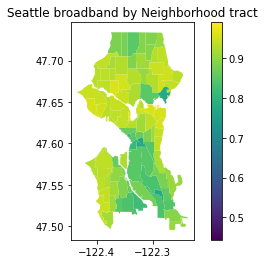

In [59]:
so.simple_map(seattle_df, 'broadband_avg', 'HOODS_', 'Seattle broadband by Neighborhood tract')

<br></br>

### City Two: Denver

In [60]:
denver_df = geopandas.read_file("/tmp/neighborhood-data/denver/denver_1.0.32/statistical_neighborhoods.shp")
denver_df.head()

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry
0,2,Auraria,None,None,"POLYGON ((-105.00042 39.74552, -105.00041 39.7..."
1,21,Cory - Merrill,None,None,"POLYGON ((-104.94070 39.69540, -104.94070 39.6..."
2,7,Belcaro,None,None,"POLYGON ((-104.94070 39.71156, -104.94069 39.7..."
3,70,Washington Park,None,None,"POLYGON ((-104.95931 39.71566, -104.95931 39.7..."
4,71,Washington Park West,None,None,"POLYGON ((-104.97342 39.68982, -104.97356 39.6..."


Census IDs from: https://denvergov.org/opendata/dataset/city-and-county-of-denver-census-tracts-2010

In [61]:
# census df
denver_census = pd.read_csv("/tmp/neighborhood-data/denver/denver_census_tracts_2010.csv")

In [62]:
denver_census.head()

,TRACT_NAME,GEOID_TRACT,GEOID_NUM,POPULATION_2010,HISPANIC_2010,WHITE_2010,BLACK_2010,NATIVE_AM_2010,ASIAN_2010,HAWPACIS_2010,...,RENTED_AGE_25_TO_34,RENTED_AGE_35_TO_44,RENTED_AGE_45_TO_54,RENTED_AGE_55_TO_59,RENTED_AGE_60_TO_64,RENTED_AGE_65_TO_74,RENTED_AGE_75_TO_84,RENTED_AGE_85_PLUS,SHAPE_Length,SHAPE_Area
0,Census Tract 17.01,8031001701,8.031002e+09,4350.0,290.0,3539.0,94.0,16.0,327.0,1.0,...,653.0,255.0,204.0,96.0,97.0,195.0,127.0,41.0,0.046437,0.000120
1,Census Tract 17.02,8031001702,8.031002e+09,3648.0,355.0,2744.0,254.0,34.0,122.0,4.0,...,619.0,215.0,216.0,117.0,68.0,63.0,30.0,10.0,0.042534,0.000117
2,Census Tract 18,8031001800,8.031002e+09,3209.0,1091.0,1810.0,128.0,33.0,75.0,0.0,...,337.0,136.0,166.0,82.0,56.0,71.0,45.0,10.0,0.047632,0.000102
3,Census Tract 19.01,8031001901,8.031002e+09,2910.0,1416.0,708.0,565.0,28.0,88.0,1.0,...,224.0,137.0,87.0,43.0,32.0,78.0,36.0,14.0,0.064075,0.000245
4,Census Tract 19.02,8031001902,8.031002e+09,705.0,62.0,555.0,27.0,5.0,29.0,2.0,...,6.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,0.055663,0.000176


In [63]:
# strint(denver_census['GEOID_NUM'][1])

In [64]:
# pull out a list of indexes:
indexes = []
for tract in denver_census['GEOID_TRACT']:
    temp = fcc_df['geoid'].isin([('0' + str(tract))])
    if True in list(temp):
        loc = list(temp).index(True)
        indexes.append(loc)

In [65]:
denver_fcc_df = fcc_df.loc[indexes]

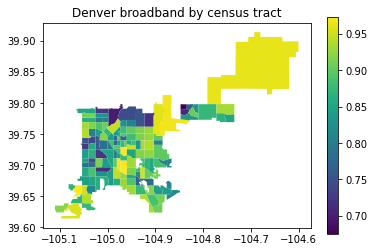

In [66]:
so.simple_map(denver_fcc_df, 'f_broadband', 'geoid', 'Denver broadband by census tract')

In [67]:
len(denver_fcc_df['geometry'])

144

In [68]:
neighborhoods = {}
indexes = []
for i, poly in enumerate(denver_fcc_df['geometry']):
    for j, nhood in enumerate(denver_df['geometry']):
        if nhood.intersects(poly):
            temp = neighborhoods.get(j, [])
            temp.append(i)
            neighborhoods[j] = temp

In [69]:
len(neighborhoods)

78

In [70]:
for i in range(78):
    a = sum(neighborhoods[i])/len(neighborhoods[i])
    print(a)

8.444444444444445
79.25
57.833333333333336
56.9
50.125
40.09090909090909
57.0
48.625
57.142857142857146
55.125
127.0
123.5
43.5
35.0
20.142857142857142
20.833333333333332
17.428571428571427
37.285714285714285
76.0
76.5
16.818181818181817
36.0
76.25
65.875
45.25
46.625
86.91666666666667
87.4
79.88888888888889
76.1
82.0909090909091
74.66666666666667
49.714285714285715
44.625
40.285714285714285
108.33333333333333
104.77777777777777
102.66666666666667
107.85714285714286
109.66666666666667
108.57142857142857
89.4
104.14285714285714
71.3
85.0
38.44444444444444
34.5
17.8
17.0
9.6
97.0
129.125
96.625
138.375
118.125
75.6
46.125
15.555555555555555
31.571428571428573
19.571428571428573
31.0
24.833333333333332
123.0
107.7
103.4
104.0
17.166666666666668
71.85714285714286
38.8
21.88888888888889
54.2
56.0
13.428571428571429
48.666666666666664
43.8
63.888888888888886
33.0
137.66666666666666


In [71]:
denver_fcc_df['f_broadband']

57744    0.874
66597    0.843
14045    0.801
5367     0.782
4906     0.921
         ...  
58809    0.874
64084    0.934
18769    0.867
2197     0.851
70928    0.973
Name: f_broadband, Length: 144, dtype: float64

In [72]:
neighborhoods[51]

[115, 116, 117, 135, 136, 137, 138, 139]

In [73]:
bband = list(denver_fcc_df['f_broadband'])

In [74]:
bband[136]

0.833

In [75]:
import math

In [76]:
normal_avgs = []
bband = list(denver_fcc_df['f_broadband'])
for i in range(78):
    s = 0
    for j in neighborhoods[i]:
        if not math.isnan(bband[j]):
            s = s + bband[j]
    normal_avgs.append(s/len(neighborhoods[i]))

In [77]:
denver_df['broadband_avg'] = normal_avgs

In [78]:
denver_df.head()

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry,broadband_avg
0,2,Auraria,None,None,"POLYGON ((-105.00042 39.74552, -105.00041 39.7...",0.845667
1,21,Cory - Merrill,None,None,"POLYGON ((-104.94070 39.69540, -104.94070 39.6...",0.926000
2,7,Belcaro,None,None,"POLYGON ((-104.94070 39.71156, -104.94069 39.7...",0.919500
3,70,Washington Park,None,None,"POLYGON ((-104.95931 39.71566, -104.95931 39.7...",0.920700
4,71,Washington Park West,None,None,"POLYGON ((-104.97342 39.68982, -104.97356 39.6...",0.895250


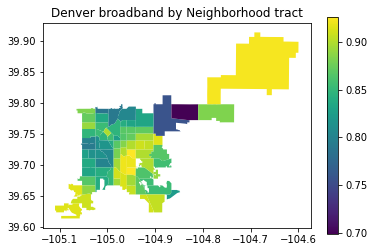

In [79]:
so.simple_map(denver_df, 'broadband_avg', 'NBHD_NAME', 'Denver broadband by Neighborhood tract')

<br></br>

### City Three: Albuquerque

cenus tract ids taken from https://www.huduser.gov/portal/qct/1metrotable.html?cbsa=10740&DDAYEAR=2021

In [80]:
alb_df = geopandas.read_file("/tmp/neighborhood-data/albuquerque/albuquerque-shp/nbr.shp")
alb_df.head()

,Associatio,Associat_1,Status,Recognitio,Type,NotifyList,ZoneMapPag,Label,PDFLink,created_us,created_da,last_edite,last_edi_1,CityCounci,GlobalID,d_Status,d_Recognit,d_Type,d_NotifyLi,geometry
0,AAN,Academy Acres North NA,Inactive,Unrecognized,Neighborhood Association,Not Applicable,E-18,AAN E-18 Academy Acres North NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGSRET,2019-12-10,4,{21A8797A-7997-469B-9318-2AA5019FECD1},Inactive,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((1541094.999 1513649.251, 1542281.374..."
1,ABH,Alban Hills NA,Active,Unrecognized,Neighborhood Association,Not Applicable,D-12,ABH D-12 Alban Hills NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGSRET,2022-02-24,1,{653ECA87-A2A0-4B5C-95CC-0DE92438E600},Active,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((1511497.475 1517476.305, 1511498.181..."
2,ABQ,ABQ Park NA,Active,Recognized,Neighborhood Association,Notify Uptown List,H-19,ABQ H-19 ABQ Park NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGIS,2018-02-13,7,{EF25FF1F-02E1-4AF7-B12D-4C0524F129E8},Active,Recognized,Neighborhood Association,Notify Uptown List,"POLYGON ((1546056.399 1492806.921, 1546112.456..."
3,ACE,Acequia Jardin HOA,Active,Unrecognized,Neighborhood Association,Not Applicable,G-12,ACE G-12 Acequia Jardin HOA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGIS,2018-02-13,2,{4CC8C244-ED90-4F12-BDE1-3E9332BDC2E8},Active,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((1513239.268 1498387.014, 1513456.014..."
4,ACN,Academy North NA,Active,Recognized,Neighborhood Association,Not Applicable,D-19,ACN D-19 Academy North NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGIS,2018-02-13,4,{4F1E9C7D-EDD5-4858-887A-44AD4BBA7651},Active,Recognized,Neighborhood Association,Not Applicable,"POLYGON ((1550435.249 1514494.126, 1550440.374..."


census tracts from here https://datausa.io/profile/geo/albuquerque-nm#about

In [81]:
# census tracts
alb_census = pd.read_csv("/tmp/neighborhood-data/albuquerque/alb-census.csv")

In [82]:
# alb_census = pd.read_csv("/tmp/neighborhood-data/albuquerque/bernalillo-county-census.csv")

In [83]:
alb_census.head()

,ID Year,Year,ID Race,Race,Household Income by Race,Household Income by Race Moe,Geography,ID Geography
0,2020,2020,0,Total,84861,24992.0,"Census Tract 1.07, Bernalillo County, NM",14000US35001000107
1,2020,2020,0,Total,49970,28594.0,"Census Tract 1.08, Bernalillo County, NM",14000US35001000108
2,2020,2020,0,Total,74813,35105.0,"Census Tract 1.09, Bernalillo County, NM",14000US35001000109
3,2020,2020,0,Total,45761,17783.0,"Census Tract 1.10, Bernalillo County, NM",14000US35001000110
4,2020,2020,0,Total,112250,24958.0,"Census Tract 1.11, Bernalillo County, NM",14000US35001000111


In [84]:
alb_census["ID Geography"].loc[0][7:]

'35001000107'

In [85]:
# pull out a list of indexes:
indexes = []
for tract in alb_census["ID Geography"]:
    temp = fcc_df.loc[fcc_df["geoid"] == str(tract)[7:]].index.values
    if temp and temp[0] not in indexes:
        indexes.append(temp[0])

In [86]:
albuquerque_fcc_df = fcc_df.loc[indexes]

In [87]:
albuquerque_fcc_df

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
71066,35001000107,6.757,6.757,2.027,1.811,0.000,0.000,1000.0,1000.0,0.906,...,2448.0,1101.0,178.36,46.93,191.89,16.60,15.88,0.073,0.019,"POLYGON ((-106.49788 35.13065, -106.49106 35.1..."
17805,35001000108,7.320,7.280,2.520,1.960,0.000,0.000,1000.0,1000.0,0.762,...,2930.0,1218.0,181.97,50.96,193.74,18.03,15.56,0.062,0.017,"POLYGON ((-106.51568 35.13066, -106.51508 35.1..."
19353,35001000109,7.735,7.735,2.500,2.029,0.029,0.029,1000.0,1000.0,0.862,...,2443.0,939.0,89.37,31.89,172.29,16.60,15.30,0.037,0.013,"POLYGON ((-106.53333 35.13064, -106.52451 35.1..."
1721,35001000110,7.152,7.152,2.485,2.000,0.000,0.000,1000.0,1000.0,0.809,...,3884.0,1589.0,168.22,43.71,138.65,12.99,15.53,0.043,0.011,"POLYGON ((-106.53329 35.12342, -106.52451 35.1..."
14692,35001000111,7.595,7.595,2.189,1.973,0.000,0.000,1000.0,1000.0,0.940,...,3042.0,1012.0,155.05,51.35,175.89,17.23,12.42,0.051,0.017,"POLYGON ((-106.51568 35.12354, -106.51125 35.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35828,35001004717,9.063,8.253,2.038,1.797,0.000,0.000,1000.0,1000.0,0.875,...,7440.0,3056.0,385.37,138.85,213.47,17.81,14.05,0.052,0.019,"POLYGON ((-106.67863 35.20247, -106.67578 35.2..."
57626,35001004740,6.343,6.321,2.463,1.799,0.007,0.007,1000.0,1000.0,0.901,...,7203.0,2358.0,184.97,67.17,199.84,14.42,14.46,0.026,0.009,"POLYGON ((-106.73113 35.07024, -106.72982 35.0..."
26812,35001004741,6.324,6.254,2.282,1.789,0.099,0.099,1000.0,1000.0,0.680,...,7253.0,2913.0,199.51,69.59,188.77,20.46,15.01,0.028,0.010,"POLYGON ((-106.74668 35.08591, -106.73922 35.0..."
48919,35001004746,8.211,7.599,2.268,1.810,0.000,0.000,1000.0,1000.0,0.825,...,8365.0,3067.0,340.82,138.13,221.28,20.25,14.52,0.041,0.017,"POLYGON ((-106.76104 35.21799, -106.73022 35.2..."


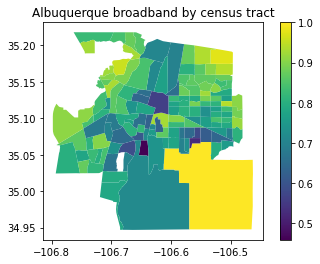

In [88]:
so.simple_map(albuquerque_fcc_df, 'f_broadband', 'geoid', 'Albuquerque broadband by census tract')

In [89]:
# transform alb_df
alb_df_trans = alb_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [90]:
alb_df_trans.head()

,Associatio,Associat_1,Status,Recognitio,Type,NotifyList,ZoneMapPag,Label,PDFLink,created_us,created_da,last_edite,last_edi_1,CityCounci,GlobalID,d_Status,d_Recognit,d_Type,d_NotifyLi,geometry
0,AAN,Academy Acres North NA,Inactive,Unrecognized,Neighborhood Association,Not Applicable,E-18,AAN E-18 Academy Acres North NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGSRET,2019-12-10,4,{21A8797A-7997-469B-9318-2AA5019FECD1},Inactive,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.58231 35.15989, -106.57834 35.1..."
1,ABH,Alban Hills NA,Active,Unrecognized,Neighborhood Association,Not Applicable,D-12,ABH D-12 Alban Hills NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGSRET,2022-02-24,1,{653ECA87-A2A0-4B5C-95CC-0DE92438E600},Active,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.68139 35.17010, -106.68139 35.1..."
2,ABQ,ABQ Park NA,Active,Recognized,Neighborhood Association,Notify Uptown List,H-19,ABQ H-19 ABQ Park NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGIS,2018-02-13,7,{EF25FF1F-02E1-4AF7-B12D-4C0524F129E8},Active,Recognized,Neighborhood Association,Notify Uptown List,"POLYGON ((-106.56549 35.10267, -106.56531 35.1..."
3,ACE,Acequia Jardin HOA,Active,Unrecognized,Neighborhood Association,Not Applicable,G-12,ACE G-12 Acequia Jardin HOA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGIS,2018-02-13,2,{4CC8C244-ED90-4F12-BDE1-3E9332BDC2E8},Active,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.67529 35.11767, -106.67457 35.1..."
4,ACN,Academy North NA,Active,Recognized,Neighborhood Association,Not Applicable,D-19,ACN D-19 Academy North NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,2018-02-13,AGIS,2018-02-13,4,{4F1E9C7D-EDD5-4858-887A-44AD4BBA7651},Active,Recognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.55107 35.16230, -106.55106 35.1..."


In [91]:
neighborhoods = {}
indexes = []
for i, poly in enumerate(albuquerque_fcc_df['geometry']):
    for j, nhood in enumerate(alb_df_trans['geometry']):
        if nhood.intersects(poly) or nhood.contains(poly):
            temp = neighborhoods.get(j, [])
            temp.append(i)
            neighborhoods[j] = temp

In [92]:
len(alb_df_trans['geometry'])

300

In [93]:
normal_avgs = []
bband = list(albuquerque_fcc_df['f_broadband'])
for i in range(300):
    s = 0
    if i in set(neighborhoods):
        for j in neighborhoods[i]:
            if not math.isnan(bband[j]):
                s = s + bband[j]
        normal_avgs.append(s/len(neighborhoods[i]))
    else:
        normal_avgs.append(None)
alb_df_trans['broadband_avg'] = normal_avgs

In [94]:
alb_df_trans.head()

,Associatio,Associat_1,Status,Recognitio,Type,NotifyList,ZoneMapPag,Label,PDFLink,created_us,...,last_edite,last_edi_1,CityCounci,GlobalID,d_Status,d_Recognit,d_Type,d_NotifyLi,geometry,broadband_avg
0,AAN,Academy Acres North NA,Inactive,Unrecognized,Neighborhood Association,Not Applicable,E-18,AAN E-18 Academy Acres North NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,...,AGSRET,2019-12-10,4,{21A8797A-7997-469B-9318-2AA5019FECD1},Inactive,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.58231 35.15989, -106.57834 35.1...",0.814667
1,ABH,Alban Hills NA,Active,Unrecognized,Neighborhood Association,Not Applicable,D-12,ABH D-12 Alban Hills NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,...,AGSRET,2022-02-24,1,{653ECA87-A2A0-4B5C-95CC-0DE92438E600},Active,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.68139 35.17010, -106.68139 35.1...",0.925500
2,ABQ,ABQ Park NA,Active,Recognized,Neighborhood Association,Notify Uptown List,H-19,ABQ H-19 ABQ Park NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,...,AGIS,2018-02-13,7,{EF25FF1F-02E1-4AF7-B12D-4C0524F129E8},Active,Recognized,Neighborhood Association,Notify Uptown List,"POLYGON ((-106.56549 35.10267, -106.56531 35.1...",0.766000
3,ACE,Acequia Jardin HOA,Active,Unrecognized,Neighborhood Association,Not Applicable,G-12,ACE G-12 Acequia Jardin HOA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,...,AGIS,2018-02-13,2,{4CC8C244-ED90-4F12-BDE1-3E9332BDC2E8},Active,Unrecognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.67529 35.11767, -106.67457 35.1...",0.740000
4,ACN,Academy North NA,Active,Recognized,Neighborhood Association,Not Applicable,D-19,ACN D-19 Academy North NA,http://data.cabq.gov/community/neighborhoods/p...,AGIS,...,AGIS,2018-02-13,4,{4F1E9C7D-EDD5-4858-887A-44AD4BBA7651},Active,Recognized,Neighborhood Association,Not Applicable,"POLYGON ((-106.55107 35.16230, -106.55106 35.1...",0.861000


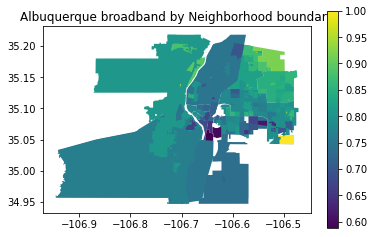

In [95]:
so.simple_map(alb_df_trans, 'broadband_avg', 'Associatio', 'Albuquerque broadband by Neighborhood boundary')

<br></br>

### City Four: Washington D.C.

In [96]:
dc_df = geopandas.read_file("/tmp/neighborhood-data/washington-dc/DC_shapefile/Neighborhood_Clusters.shp")
dc_df.head()

,OBJECTID,WEB_URL,NAME,NBH_NAMES,TYPE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,http://planning.dc.gov/,Cluster 16,"Colonial Village, Shepherd Park, North Portal ...",Original,{8D235E97-D58C-4891-943E-307143103BD9},None,None,None,None,0,0,"POLYGON ((-77.02829 38.98608, -77.02662 38.984..."
1,2,None,Cluster 41,Rock Creek Park,Additional,{939C23A8-8EE2-4B4F-85EE-88281BCCC9A0},None,None,None,None,0,0,"POLYGON ((-77.04391 38.98432, -77.04370 38.984..."
2,3,http://planning.dc.gov/,Cluster 10,"Hawthorne, Barnaby Woods, Chevy Chase",Original,{8EADC8B8-3DAD-4E5D-AAF8-BF63D8316317},None,None,None,None,0,0,"POLYGON ((-77.05530 38.95900, -77.05554 38.958..."
3,4,http://planning.dc.gov/,Cluster 17,"Takoma, Brightwood, Manor Park",Original,{5BF4BCEC-5022-4B96-9577-C0246154197C},None,None,None,None,0,0,"POLYGON ((-77.01418 38.97237, -77.01432 38.972..."
4,5,None,Cluster 40,Walter Reed,Additional,{C6705A7B-212E-419A-93CB-DA60707D0C37},None,None,None,None,0,0,"POLYGON ((-77.03286 38.97800, -77.03198 38.978..."


census ids from https://opendata.dc.gov/datasets/DCGIS::census-tracts-in-2020/about

In [97]:
# census df
dc_census = pd.read_csv("/tmp/neighborhood-data/washington-dc/washington-dc-census-tract.csv")

In [98]:
dc_census.head()

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,SHAPEAREA,SHAPELEN
0,1,2002,11001002002,4072,3647,1116,1751,27,84,0,...,0,0,0,0,32,0,0,32,0,0
1,2,2101,11001002101,5687,5071,1037,2642,86,120,1,...,0,0,0,0,31,0,0,31,0,0
2,3,2102,11001002102,5099,4599,901,2910,50,87,0,...,0,0,0,0,145,0,0,145,0,0
3,4,2201,11001002201,3485,3138,973,1722,21,94,2,...,0,6,0,0,0,0,0,0,0,0
4,5,2202,11001002202,3339,2957,619,1636,48,57,3,...,0,0,0,0,4,0,0,4,0,0


In [99]:
fcc_df.loc[fcc_df["geoid"] == "11001002002"].index.values

array([43295])

In [100]:
# pull out a list of indexes:
indexes = []
for tract in dc_census['GEOID']:
    temp = fcc_df.loc[fcc_df["geoid"] == str(tract)].index.values
    if temp:
        indexes.append(temp[0])

In [101]:
indexes

[43295,
 1542,
 61239,
 43173,
 7914,
 15692,
 57149,
 36088,
 60420,
 21703,
 54187,
 7146,
 10154,
 20994,
 43297,
 14281,
 38602,
 44986,
 69799,
 6968,
 16187,
 43314,
 72822,
 8055,
 20940,
 38200,
 20941,
 59754,
 54272,
 43195,
 55162,
 38201,
 68985,
 43296,
 64316,
 9093,
 27932,
 1878,
 11680,
 32265,
 16915,
 17811,
 38802,
 45457,
 9530,
 19567,
 24590,
 32575,
 1874,
 32323,
 16293,
 6165,
 15358,
 5620,
 51968,
 5621,
 6469,
 19105,
 6317,
 2272,
 22474,
 62666,
 51969,
 10797,
 10951,
 17546,
 57502,
 15114,
 67554,
 10224,
 32433,
 58399,
 64554,
 17195,
 31255,
 64381,
 45846,
 45847,
 26494,
 57503,
 38601,
 56103,
 59110,
 63306,
 21702,
 2107,
 17196,
 30937,
 14696,
 12667,
 34975,
 13057,
 46231,
 3077,
 7915,
 64020,
 8043,
 26341,
 1877,
 42017,
 62821,
 10409,
 844,
 20579,
 72486,
 65547,
 14885,
 53638,
 41203,
 8712,
 69624,
 10089,
 17802,
 42018,
 32443,
 34328,
 56912,
 68761,
 61573,
 53569,
 38801,
 25340,
 11773,
 62927,
 4709,
 37367,
 300,
 13024,
 1

In [102]:
dc_fcc_df = fcc_df.loc[indexes]

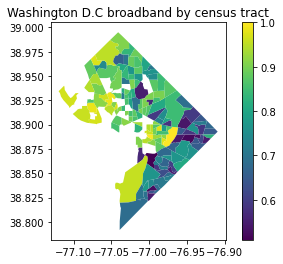

In [103]:
so.simple_map(dc_fcc_df, 'f_broadband', 'geoid', 'Washington D.C broadband by census tract')

In [104]:
neighborhoods = {}
indexes = []
for i, poly in enumerate(dc_fcc_df['geometry']):
    for j, nhood in enumerate(dc_df['geometry']):
        if nhood.intersects(poly):
            temp = neighborhoods.get(j, [])
            temp.append(i)
            neighborhoods[j] = temp

In [105]:
neighborhoods

{3: [0, 1, 2, 22, 23, 24, 25, 26, 27, 28, 123, 125, 147],
 7: [0, 1, 2, 3, 4, 24, 25, 26, 28, 29, 30, 31, 32, 33, 37, 39, 40],
 5: [2, 4, 23, 27, 29, 30, 121, 123, 124, 125, 126],
 16: [4,
  29,
  30,
  31,
  40,
  41,
  42,
  43,
  52,
  54,
  55,
  106,
  107,
  109,
  114,
  115,
  116,
  117,
  118,
  119],
 28: [5, 6, 7, 8, 13, 48],
 15: [6, 13, 14],
 17: [6, 7, 8, 11, 12, 13, 15],
 22: [6, 13, 14, 59, 70, 101, 146, 149, 150, 151, 152],
 18: [8, 9, 10, 11, 15, 17, 46, 48],
 25: [8],
 1: [9, 18, 21, 22, 24, 28, 33, 34],
 24: [9, 34, 46, 47, 48, 49],
 8: [11, 16, 17, 18, 20, 33],
 6: [15, 16, 17],
 2: [16, 18, 19, 20, 21],
 0: [21, 22, 147],
 4: [22, 25, 147],
 14: [30, 115, 118, 120, 121, 122, 125, 126],
 21: [30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 51],
 23: [30, 40, 41, 43, 44, 45, 51, 52, 54],
 26: [47, 48, 49, 50, 51, 146, 150],
 31: [51, 52, 54, 55, 56, 57, 58, 146],
 35: [52, 53, 66, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109],
 36: [52, 53, 55, 5

In [106]:
len(neighborhoods)

46

In [107]:
dc_df.shape

(46, 13)

In [108]:
normal_avgs = []
bband = list(dc_fcc_df['f_broadband'])
for key, val in neighborhoods.items():
    s = 0
    for j in val:
        s = s + float(bband[j])
    normal_avgs.append(s/len(val))

In [109]:
dc_df['broadband_avg'] = normal_avgs

In [110]:
dc_df.head()

,OBJECTID,WEB_URL,NAME,NBH_NAMES,TYPE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry,broadband_avg
0,1,http://planning.dc.gov/,Cluster 16,"Colonial Village, Shepherd Park, North Portal ...",Original,{8D235E97-D58C-4891-943E-307143103BD9},None,None,None,None,0,0,"POLYGON ((-77.02829 38.98608, -77.02662 38.984...",0.813692
1,2,None,Cluster 41,Rock Creek Park,Additional,{939C23A8-8EE2-4B4F-85EE-88281BCCC9A0},None,None,None,None,0,0,"POLYGON ((-77.04391 38.98432, -77.04370 38.984...",0.797412
2,3,http://planning.dc.gov/,Cluster 10,"Hawthorne, Barnaby Woods, Chevy Chase",Original,{8EADC8B8-3DAD-4E5D-AAF8-BF63D8316317},None,None,None,None,0,0,"POLYGON ((-77.05530 38.95900, -77.05554 38.958...",0.786182
3,4,http://planning.dc.gov/,Cluster 17,"Takoma, Brightwood, Manor Park",Original,{5BF4BCEC-5022-4B96-9577-C0246154197C},None,None,None,None,0,0,"POLYGON ((-77.01418 38.97237, -77.01432 38.972...",0.808750
4,5,None,Cluster 40,Walter Reed,Additional,{C6705A7B-212E-419A-93CB-DA60707D0C37},None,None,None,None,0,0,"POLYGON ((-77.03286 38.97800, -77.03198 38.978...",NaN


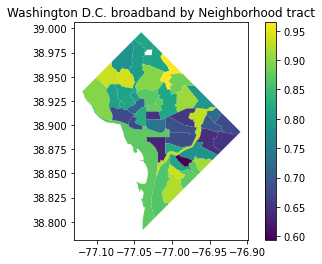

In [111]:
so.simple_map(dc_df, 'broadband_avg', 'OBJECTID', 'Washington D.C. broadband by Neighborhood tract')

<br></br>

### City Five: Boston

In [112]:
boston_df = geopandas.read_file("/tmp/neighborhood-data/boston/Boston_Neighborhoods/Boston_Neighborhoods.shp")
boston_df.head()

,OBJECTID,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12575 ..."
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10488 42.326..."
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09275 42.333..."
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09892 42.336..."
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06739 42.348..."


census ids from https://data.boston.gov/dataset/2020-census-for-boston/resource/013aba13-5985-4067-bba4-a8d3ca9a34ac

In [113]:
# census df
boston_census = pd.read_csv("/tmp/neighborhood-data/boston/boston-census.csv")

In [114]:
boston_census

,FILEID,STUSAB,SUMLEV,GEOID,GEOCODE,REGION,DIVISION,STATE,COUNTY,COUSUB,...,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,H0010001,H0010002,H0010003
0,field concept,State/US-Abbreviation (USPS),Summary Level,Geographic Record Identifier,Geographic Code Identifier,Region,Division,State (FIPS),County (FIPS),County Subdivision (FIPS),...,Juvenile facilities,Nursing facilities/Skilled-nursing facilities,Other institutional facilities,Noninstitutionalized population:,College/University student housing,Military quarters,Other noninstitutional facilities,Total:,Occupied,Vacant
1,PLST,MA,140,1400000US25025000101,25025000101,1,1,25,25,NaN,...,0,0,0,10,0,0,10,726,697,29
2,PLST,MA,140,1400000US25025000102,25025000102,1,1,25,25,NaN,...,7,0,0,10,0,0,10,1695,1606,89
3,PLST,MA,140,1400000US25025000201,25025000201,1,1,25,25,NaN,...,6,0,0,39,0,0,39,1608,1544,64
4,PLST,MA,140,1400000US25025000202,25025000202,1,1,25,25,NaN,...,0,0,0,41,0,0,41,1606,1539,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,PLST,MA,140,1400000US25025981600,25025981600,1,1,25,25,NaN,...,0,0,0,0,0,0,0,1,1,0
204,PLST,MA,140,1400000US25025981700,25025981700,1,1,25,25,NaN,...,0,0,0,0,0,0,0,2,2,0
205,PLST,MA,140,1400000US25025981800,25025981800,1,1,25,25,NaN,...,0,0,0,8,0,0,8,10,4,6
206,PLST,MA,140,1400000US25025981900,25025981900,1,1,25,25,NaN,...,0,0,0,0,0,0,0,0,0,0


In [115]:
fcc_df.loc[fcc_df["geoid"] == '25025990101']

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
66288,25025990101,1.0,1.0,0.0,0.0,0.0,0.0,50.0,50.0,1.0,...,67.0,12.0,13.3,6.05,225.59,99.82,34.5,0.199,0.09,"MULTIPOLYGON (((-71.02778 42.33025, -71.02507 ..."


In [116]:
# pull out a list of indexes:
indexes = []
for tract in boston_census['GEOCODE']:
    temp = fcc_df.loc[fcc_df["geoid"] == str(tract)].index.values
    if temp:
        indexes.append(temp[0])

In [117]:
boston_fcc_df = fcc_df.loc[indexes]

In [118]:
boston_fcc_df

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
39852,25025000201,5.815,5.704,4.556,3.667,0.889,0.889,963.019,784.815,0.923,...,4125.0,1567.0,119.89,49.03,251.99,42.25,12.11,0.029,0.012,"POLYGON ((-71.16764 42.35379, -71.16520 42.353..."
45028,25025000202,6.292,6.208,5.042,4.042,1.000,1.000,1000.000,880.000,0.928,...,4461.0,1516.0,132.30,55.29,256.05,63.29,12.88,0.030,0.012,"POLYGON ((-71.16057 42.35267, -71.15859 42.353..."
20104,25025000301,4.960,4.560,3.760,3.440,0.840,0.840,941.000,742.920,0.934,...,3074.0,1168.0,53.62,26.81,275.74,58.43,11.87,0.017,0.009,"POLYGON ((-71.17480 42.35026, -71.17394 42.353..."
5862,25025000302,5.474,5.211,4.474,3.632,1.000,1.000,996.842,880.000,0.944,...,3447.0,1296.0,71.32,33.17,291.84,86.70,11.43,0.021,0.010,"POLYGON ((-71.17471 42.35015, -71.16970 42.349..."
64599,25025000401,5.739,5.739,4.565,3.565,0.913,0.870,1000.000,784.130,0.796,...,5696.0,2668.0,175.61,54.03,223.31,58.47,12.19,0.031,0.009,"POLYGON ((-71.15473 42.34121, -71.15346 42.343..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35665,25025981501,1.190,1.139,0.114,0.114,0.000,0.000,158.228,49.620,NaN,...,0.0,0.0,261.09,99.38,220.05,44.02,14.72,NaN,NaN,"POLYGON ((-71.16763 42.36007, -71.16327 42.358..."
6091,25025981600,2.000,1.000,1.000,1.000,0.500,0.500,502.500,440.000,NaN,...,0.0,0.0,19.48,9.82,186.07,41.71,25.59,NaN,NaN,"POLYGON ((-70.99939 42.38833, -70.99535 42.389..."
3324,25025981700,3.333,3.333,1.333,1.333,0.333,0.333,1000.000,326.667,NaN,...,0.0,0.0,220.67,84.26,190.69,41.42,13.68,NaN,NaN,"POLYGON ((-71.07256 42.35544, -71.07130 42.355..."
36169,25025981800,1.455,1.273,0.295,0.295,0.045,0.045,297.727,89.773,1.000,...,32.0,14.0,224.77,89.38,214.61,50.63,12.41,7.024,2.793,"POLYGON ((-71.12572 42.31843, -71.11982 42.321..."


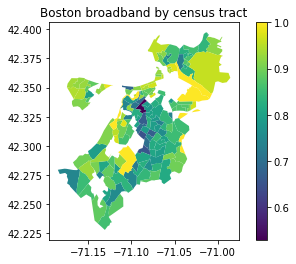

In [119]:
so.simple_map(boston_fcc_df, 'f_broadband', 'geoid', 'Boston broadband by census tract')

In [120]:
neighborhoods = {}
indexes = []
for i, poly in enumerate(boston_fcc_df['geometry']):
    for j, nhood in enumerate(boston_df['geometry']):
        if nhood.intersects(poly):
            temp = neighborhoods.get(j, [])
            temp.append(i)
            neighborhoods[j] = temp

In [121]:
neighborhoods

{17: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 155],
 24: [8, 9, 10, 11, 12, 155],
 16: [12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 70, 155, 158],
 10: [13, 16, 18, 20, 21, 22, 23, 24, 25, 26, 62, 155, 157],
 3: [15, 70, 71, 72, 158],
 2: [18, 69, 70, 71, 72, 73, 74, 133, 158],
 8: [18,
  63,
  65,
  66,
  67,
  68,
  69,
  70,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  91,
  92,
  103,
  128,
  129,
  148,
  151],
 14: [23, 24, 26, 27, 28, 29, 155, 157],
 15: [23, 29, 31, 32, 60, 157],
 13: [27, 28, 29, 31, 37, 155],
 7: [30, 31, 32, 33],
 12: [34, 35, 36, 37, 38, 39],
 11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 154, 156],
 23: [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 86, 87, 152, 153],
 21: [59,
  65,
  77,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  115,
  116,
  148,
  

In [122]:
len(neighborhoods)

24

In [123]:
boston_df.shape

(26, 8)

In [124]:
normal_avgs = []
bband = list(boston_fcc_df['f_broadband'])
for key, val in neighborhoods.items():
    s = 0
    for j in val:
         if not math.isnan(bband[j]):
#             s = s + bband[j]
            s = s + float(bband[j])
    normal_avgs.append(s/len(val))

In [125]:
len(normal_avgs)

24

In [126]:
boston_df = boston_df.drop([4, 5])

In [127]:
boston_df['broadband_avg'] = normal_avgs

In [128]:
boston_df.head()

,OBJECTID,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry,broadband_avg
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12575 ...",0.823636
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10488 42.326...",0.734833
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09275 42.333...",0.799214
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09892 42.336...",0.760846
6,33,Chinatown,76.324410,26,0.12,3.324678e+06,9736.590413,"POLYGON ((-71.05791 42.35238, -71.05796 42.352...",0.832800


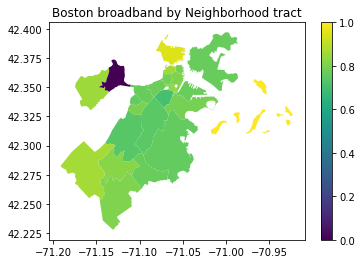

In [129]:
so.simple_map(boston_df, 'broadband_avg', 'Neighborho', 'Boston broadband by Neighborhood tract')

<br></br>

### City Four: Portland

census tracts from here https://datausa.io/profile/geo/portland-or/#about

In [130]:
portland_df = geopandas.read_file("/tmp/neighborhood-data/portland/portland-neighborhood-boundaries/Neighborhood_Boundaries.shp")
portland_df.head()

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,ID,geometry
0,1,LINNTON,None,N,NWNW,HORZ,53244.045538,Linnton,1,"POLYGON ((-13669901.863 5719574.412, -13669574..."
1,2,FOREST PARK/LINNTON,None,Y,NWNW,None,57723.635350,Forest Park/Linnton,2,"POLYGON ((-13672615.072 5717458.598, -13672601..."
2,3,FOREST PARK,None,N,NWNW,HORZ,82725.497522,Forest Park,3,"POLYGON ((-13669096.892 5708277.357, -13669210..."
3,4,CATHEDRAL PARK,None,N,NPNS,HORZ,11434.254777,Cathedral Park,4,"POLYGON ((-13666093.373 5714122.821, -13666569..."
4,5,UNIVERSITY PARK,None,N,NPNS,HORZ,11950.859827,University Park,5,"POLYGON ((-13663193.115 5713925.450, -13662883..."


In [131]:
portland_census = pd.read_csv("/tmp/neighborhood-data/portland/portland-census.csv")
portland_census.head()

,ID Year,Year,ID Race,Race,Household Income by Race,Household Income by Race Moe,Geography,ID Geography
0,2020,2020,0,Total,58617,4726.0,"Census Tract 208, Clackamas County, OR",14000US41005020800
1,2020,2020,0,Total,66793,6139.0,"Census Tract 209, Clackamas County, OR",14000US41005020900
2,2020,2020,0,Total,86524,13253.0,"Census Tract 210, Clackamas County, OR",14000US41005021000
3,2020,2020,0,Total,55977,9917.0,"Census Tract 216.01, Clackamas County, OR",14000US41005021601
4,2020,2020,0,Total,111974,22512.0,"Census Tract 222.06, Clackamas County, OR",14000US41005022206


In [132]:
# pull out a list of indexes:
indexes = []
for tract in portland_census["ID Geography"]:
    temp = fcc_df.loc[fcc_df["geoid"] == str(tract)[7:]].index.values
    if temp and temp[0] not in indexes:
        indexes.append(temp[0])

In [133]:
portland_fcc_df = fcc_df.loc[indexes]

In [134]:
portland_fcc_df

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
45577,41005020800,3.088,2.816,1.395,1.202,0.386,0.386,817.018,393.509,0.800,...,4143.0,2057.0,211.34,98.27,207.81,75.82,13.23,0.051,0.024,"POLYGON ((-122.66098 45.45781, -122.65697 45.4..."
58633,41005020900,3.816,3.714,2.000,1.837,0.878,0.878,960.000,831.020,0.856,...,4410.0,1715.0,111.92,47.91,244.85,121.31,11.38,0.025,0.011,"POLYGON ((-122.63656 45.46147, -122.63297 45.4..."
36984,41005021000,3.849,3.640,1.884,1.721,0.814,0.814,932.326,774.419,0.804,...,4891.0,2023.0,225.94,79.62,208.11,118.41,8.51,0.046,0.016,"POLYGON ((-122.62223 45.45140, -122.62014 45.4..."
69116,41005021601,3.921,3.703,1.911,1.703,0.792,0.792,924.158,754.950,0.869,...,6515.0,2485.0,268.49,70.41,223.94,71.86,12.21,0.041,0.011,"POLYGON ((-122.60145 45.46146, -122.59766 45.4..."
48844,41005022206,3.586,3.485,1.525,1.232,0.434,0.414,826.667,424.040,0.968,...,6833.0,2524.0,498.65,146.85,251.75,29.81,16.68,0.073,0.021,"POLYGON ((-122.57305 45.45738, -122.57131 45.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21705,41051008901,4.083,3.817,1.550,1.275,0.425,0.425,863.750,425.750,0.908,...,10754.0,3262.0,576.00,179.19,198.59,32.23,14.39,0.054,0.017,"POLYGON ((-122.54938 45.47604, -122.54548 45.4..."
31839,41051009000,4.714,4.595,2.429,1.905,0.952,0.952,975.952,897.262,0.832,...,11175.0,3418.0,306.73,83.02,218.33,89.32,11.78,0.027,0.007,"POLYGON ((-122.53780 45.48742, -122.53770 45.4..."
15511,41051009201,3.741,3.362,1.983,1.690,0.793,0.793,898.621,751.207,0.818,...,7868.0,2942.0,278.24,89.97,241.98,71.01,12.18,0.035,0.011,"POLYGON ((-122.53777 45.52249, -122.52751 45.5..."
21764,41051009702,4.374,4.215,2.645,1.785,0.916,0.813,885.607,784.439,0.780,...,8442.0,2696.0,242.10,71.52,239.84,100.30,13.54,0.029,0.008,"POLYGON ((-122.49660 45.50700, -122.49655 45.5..."


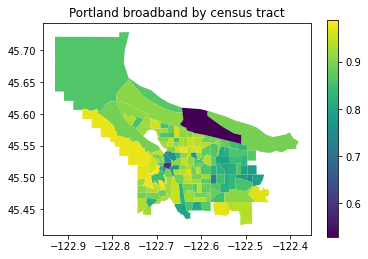

In [135]:
so.simple_map(portland_fcc_df, 'f_broadband', 'geoid', 'Portland broadband by census tract')

In [136]:
# transform alb_df
portland_df_trans = portland_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [137]:
neighborhoods = {}
indexes = []
for i, poly in enumerate(portland_fcc_df['geometry']):
    for j, nhood in enumerate(portland_df_trans['geometry']):
        if nhood.intersects(poly) or nhood.contains(poly):
            temp = neighborhoods.get(j, [])
            temp.append(i)
            neighborhoods[j] = temp

In [138]:
normal_avgs = []
bband = list(portland_fcc_df['f_broadband'])
for i in range(130):
    s = 0
    if i in set(neighborhoods):
        for j in neighborhoods[i]:
            if not math.isnan(bband[j]):
                s = s + bband[j]
        normal_avgs.append(s/len(neighborhoods[i]))
    else:
        normal_avgs.append(None)
portland_df_trans['broadband_avg'] = normal_avgs

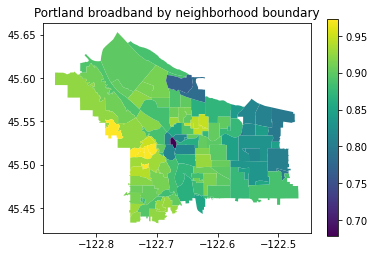

In [139]:
so.simple_map(portland_df_trans, 'broadband_avg', 'OBJECTID', 'Portland broadband by neighborhood boundary')

In [140]:
sanfransisco_df = geopandas.read_file("/tmp/neighborhood-data/san-fransisco/SF Find Neighborhoods/geo_export_f62da660-837f-478c-9ba4-ceb40e9ed8eb.shp")

In [141]:
sanfransisco_fcc_df = merge_data(sanfransisco_df, fcc_df, "/tmp/neighborhood-data/san-fransisco/sanfransisco_fcc_df.geojson")

In [145]:
columbus_df = geopandas.read_file("/tmp/neighborhood-data/columbus/Columbus_Communities/Columbus_Communities.shp")

In [146]:
columbus_fcc_df = merge_data(columbus_df, fcc_df, "/tmp/neighborhood-data/columbus/columbus_fcc_df.geojson")

In [148]:
indianapolis_df = geopandas.read_file("/tmp/neighborhood-data/indianapolis/Indy_Neighborhoods/Indy_Neighborhoods.shp")

In [149]:
indianapolis_fcc_df = merge_data(indianapolis_df, fcc_df, "/tmp/neighborhood-data/indianapolis/indianapolis_fcc_df.geojson")

In [151]:
charlotte_df = geopandas.read_file("/tmp/neighborhood-data/charlotte/Historic_Districts/Historic_Districts.shp")

In [152]:
charlotte_fcc_df = merge_data(charlotte_df, fcc_df, "/tmp/neighborhood-data/charlotte/charlotte_fcc_df.geojson")